In [1]:
#!pip install astral

In [2]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
from skforecast.datasets import fetch_dataset

# Plots & Metrics
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
from sklearn.metrics import mean_squared_error, mean_absolute_error
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size':8})

# Modelling and Forecasting
# ==============================================================================
import skforecast
import lightgbm
import sklearn
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import select_features
import shap
shap.initjs()

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

print(f"Versión skforecast: {skforecast.__version__}")
print(f"Versión lightgbm: {lightgbm.__version__}")
print(f"Versión scikit-learn: {sklearn.__version__}")

Versión skforecast: 0.12.1
Versión lightgbm: 4.3.0
Versión scikit-learn: 1.2.2


In [3]:
#df_2022 = pd.read_excel("C:/Users/Ahmet/Desktop/EPİAŞ(UEVM)/Uzlastirma_Esas_Veris_Miktari-01012022-31122022.xlsx")
#df_2023 = pd.read_excel("C:/Users/Ahmet/Desktop/EPİAŞ(UEVM)/Uzlastirma_Esas_Veris_Miktari-01012023-31122023.xlsx")
#df_2024 = pd.read_excel("C:/Users/Ahmet/Desktop/EPİAŞ(UEVM)/Uzlastirma_Esas_Veris_Miktari-01012024-30042024.xlsx")
df_2022 = pd.read_excel(r"C:\Users\Ahmet\Desktop\Yeni klasör (2)\Gercek_Zamanli_Uretim-01012022-31122022.xlsx")
df_2023 = pd.read_excel(r"C:\Users\Ahmet\Desktop\Yeni klasör (2)\Gercek_Zamanli_Uretim-01012023-31122023.xlsx")
df_2024 = pd.read_excel(r"C:\Users\Ahmet\Desktop\Yeni klasör (2)\Gercek_Zamanli_Uretim-01012024-30042024.xlsx")


c:\Users\Ahmet\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

c:\Users\Ahmet\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

c:\Users\Ahmet\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



In [4]:
combined_df = pd.concat([df_2022, df_2023, df_2024])

In [5]:
combined_df = combined_df.reset_index(drop=True)

In [6]:
tarihler = pd.date_range("2022", periods=len(combined_df["Tarih"]), freq= "H") # gün ay yıl olarak tarih eklemek icin (datetime formatinda)
combined_df["Tarih"] = tarihler
combined_df.set_index(combined_df["Tarih"], inplace=True)
combined_df.drop("Tarih", axis=1, inplace=True)

In [7]:
combined_df.tail()

Saat    Toplam  Doğal Gaz   Barajlı   Linyit   Akarsu  \
Tarih                                                                         
2024-04-30 19:00:00  19:00  40092.71    4659.85  11397.52  4087.89  4363.49   
2024-04-30 20:00:00  20:00  40875.02    4573.67  12366.09  4072.67  4422.71   
2024-04-30 21:00:00  21:00  39369.42    4182.61  11269.77  4069.63  4295.46   
2024-04-30 22:00:00  22:00  38045.64    4252.65  10085.53  4046.46  4189.62   
2024-04-30 23:00:00  23:00  36166.51    3675.74   9505.10  3980.55  4081.77   

                     İthal Kömür   Rüzgar  Güneş  Fuel Oil  Jeotermal  \
Tarih                                                                   
2024-04-30 19:00:00      6015.89  6913.12  17.18     93.72    1069.90   
2024-04-30 20:00:00      6018.44  6763.11   0.13     93.11    1096.49   
2024-04-30 21:00:00      6014.61  6845.11   0.01     92.71    1115.88   
2024-04-30 22:00:00      6009.07  6716.23   0.01     89.58    1129.58   
2024-04-30 23:00:00      5967.44  6213.43   0.01     86.28    1143.72   

                     Asfaltit Kömür  Taş Kömür  Biyokütle  Nafta  LNG  \
Tarih                                                                   
2024-04-30 19:00:00             0.0     485.06     991.85      0    0   
2024-04-30 20:00:00             0.0     483.46     998.43      0    0   
2024-04-30 21:00:00             0.0     478.68     989.27      0    0   
2024-04-30 22:00:00             0.0     457.46     971.74      0    0   
2024-04-30 23:00:00             0.0     469.52     964.60      0    0   

                     Uluslararası  Atık Isı  
Tarih                                        
2024-04-30 19:00:00        -79.43     76.67  
2024-04-30 20:00:00        -91.88     78.59  
2024-04-30 21:00:00        -63.89     79.57  
2024-04-30 22:00:00         17.40     80.31  
2024-04-30 23:00:00          0.00     78.35

In [8]:
df = combined_df.drop(columns= ["Saat"], axis=1).copy()

In [9]:
df.isnull().sum()

Toplam            0
Doğal Gaz         0
Barajlı           0
Linyit            0
Akarsu            0
İthal Kömür       0
Rüzgar            0
Güneş             0
Fuel Oil          0
Jeotermal         0
Asfaltit Kömür    0
Taş Kömür         0
Biyokütle         0
Nafta             0
LNG               0
Uluslararası      0
Atık Isı          0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20424 entries, 2022-01-01 00:00:00 to 2024-04-30 23:00:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Toplam          20424 non-null  float64
 1   Doğal Gaz       20424 non-null  float64
 2   Barajlı         20424 non-null  float64
 3   Linyit          20424 non-null  float64
 4   Akarsu          20424 non-null  float64
 5   İthal Kömür     20424 non-null  float64
 6   Rüzgar          20424 non-null  float64
 7   Güneş           20424 non-null  float64
 8   Fuel Oil        20424 non-null  float64
 9   Jeotermal       20424 non-null  float64
 10  Asfaltit Kömür  20424 non-null  float64
 11  Taş Kömür       20424 non-null  float64
 12  Biyokütle       20424 non-null  float64
 13  Nafta           20424 non-null  int64  
 14  LNG             20424 non-null  int64  
 15  Uluslararası    20424 non-null  float64
 16  Atık Isı        20424 non-null  float64
d

In [11]:
# Veriyi tarih bazında sıralama
data = df.sort_index()
data = data.asfreq('H')

# Eğitim, doğrulama ve test tarihlerini belirleme
end_train = '2023-8-15 23:59:00'
end_validation = '2024-03-31 23:59:00'

data_train = data.loc[:end_train].copy()
data_val = data.loc[end_train:end_validation].copy()
data_test = data.loc[end_validation:].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Train dates      : 2022-01-01 00:00:00 --- 2023-08-15 23:00:00  (n=14208)
Validation dates : 2023-08-16 00:00:00 --- 2024-03-31 23:00:00  (n=5496)
Test dates       : 2024-04-01 00:00:00 --- 2024-04-30 23:00:00  (n=720)


In [12]:
# Zaman serilerinin interaktif grafiği
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['Toplam'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=data_val.index, y=data_val['Toplam'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['Toplam'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Saatlik enerji üretimi',
    xaxis_title="Zaman",
    yaxis_title="Toplam",
    legend_title="Bölünme:",
    width=850,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
#fig.update_xaxes(rangeslider_visible=True)
fig.show()


#### Grafik elektrik üretiminin yıllık bir mevsimselliğe sahip olduğunu göstermektedir. Temmuz-Ağustos ayında bir zirve yaşanmakta.

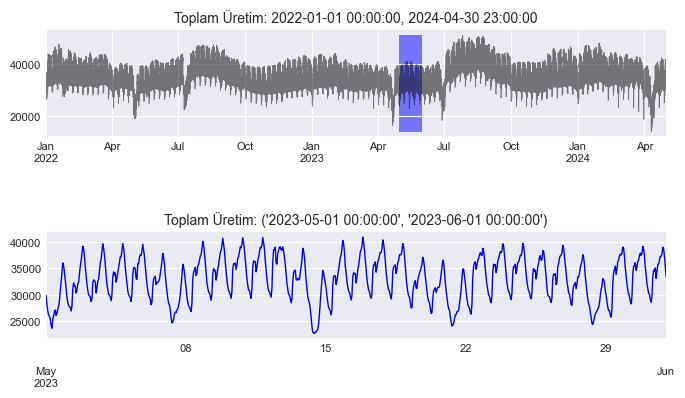

In [13]:
# Zaman serisi grafiğini yakınlaştırma
# ==============================================================================
zoom = ('2023-05-01 00:00:00', '2023-06-01 00:00:00')
fig = plt.figure(figsize=(8, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)
main_ax = fig.add_subplot(grid[:3, :])
data.Toplam.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(data.Toplam)
max_y = max(data.Toplam)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_title(f'Toplam Üretim: {data.index.min()}, {data.index.max()}', fontsize=10)
main_ax.set_xlabel('')
zoom_ax = fig.add_subplot(grid[5:, :])
data.loc[zoom[0]: zoom[1]].Toplam.plot(ax=zoom_ax, color='blue', linewidth=1)
zoom_ax.set_title(f'Toplam Üretim: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)
plt.show();



#### Zaman serileri yakınlaştırıldığında, iş günlerinde (Pazartesi'den Cuma'ya) daha yüksek üretim ve hafta sonlarında daha düşük üretim ile net bir haftalık mevsimsellik görülebilir. Ayrıca bir günün üretimi ile bir önceki günün üretimi arasında da açık bir korelasyon vardır.

# Mevsimsel grafikler

### Mevsimsel grafikler, bir zaman serisindeki mevsimsel kalıpları ve eğilimleri belirlemek için yararlı bir araçtır. Her mevsimin değerlerinin zaman içinde ortalaması alınarak ve ardından zamana karşı çizilerek oluşturulurlar.

##### Yıllık, haftalık ve günlük mevsimsellik :

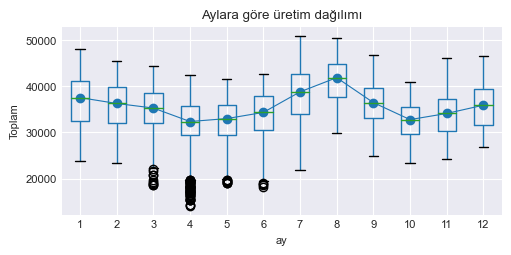

In [14]:
# Aylara göre üretim dağılımı
# ==============================================================================
fig, ax = plt.subplots(figsize=(5.5, 2.5))
data['ay'] = data.index.month
data.boxplot(column='Toplam', by='ay', ax=ax,)
data.groupby('ay')['Toplam'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Toplam')
ax.set_title('Aylara göre üretim dağılımı')
fig.suptitle('')
plt.show();

#### Temmuz, Ağustos ve Eylül aylarında daha yüksek (medyan) üretim değerleri ile yıllık bir mevsimsellik olduğu görülmektedir.

##### Haftanın günlerine göre üretim dağılımı :

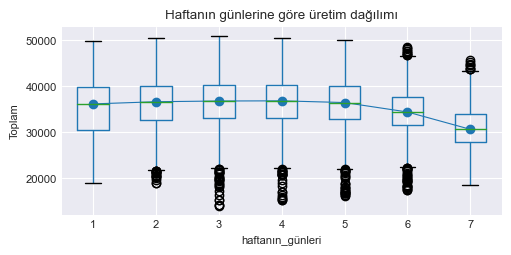

In [15]:
# Haftanın günlerine göre üretim dağılımı
# ==============================================================================
fig, ax = plt.subplots(figsize=(5.5, 2.5))
data['haftanın_günleri'] = data.index.day_of_week + 1
data.boxplot(column='Toplam', by='haftanın_günleri', ax=ax)
data.groupby('haftanın_günleri')['Toplam'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Toplam')
ax.set_title('Haftanın günlerine göre üretim dağılımı')
fig.suptitle('')
plt.show();

#### Haftalık mevsimsellik, hafta sonu boyunca daha düşük talep değerleri göstermektedir.

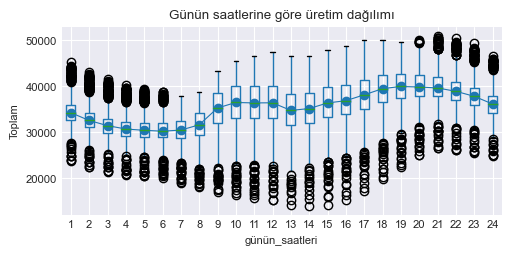

In [16]:
# Günün saatlerine göre üretim dağılımı
# ==============================================================================
fig, ax = plt.subplots(figsize=(5.5, 2.5))
data['günün_saatleri'] = data.index.hour + 1
data.boxplot(column='Toplam', by='günün_saatleri', ax=ax)
data.groupby('günün_saatleri')['Toplam'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Toplam')
ax.set_title('Günün saatlerine göre üretim dağılımı')
fig.suptitle('')
plt.show();

#### Günlük mevsimsellik de söz konusudur ve üretim 9:00 ile 22:00 saatleri arasında artmaktadır.

# Otokorelasyon grafikleri

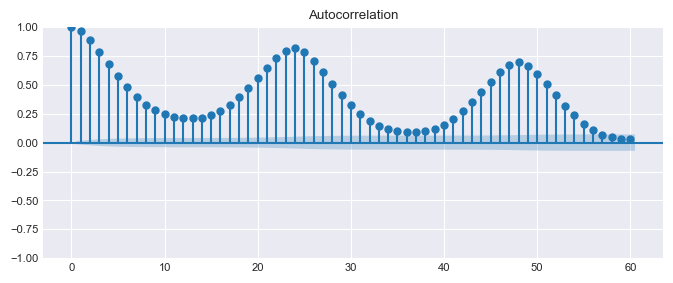

In [17]:
# Otokorelasyon grafiği
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
plot_acf(data.Toplam, ax=ax, lags=60)
plt.show()

c:\Users\Ahmet\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



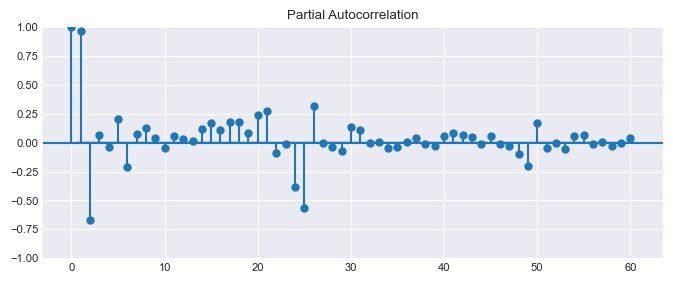

In [18]:
# Kısmi otokorelasyon grafiği
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
plot_pacf(data.Toplam, ax=ax, lags=60)
plt.show()

#### Otokorelasyon grafiği, bir saatteki üretim ile önceki saatler arasında ve ayrıca bir saatteki üretim ile önceki günlerdeki ilgili saat arasında güçlü bir korelasyon olduğunu göstermektedir. Gözlemlenen bu korelasyon, otoregresif modellerin bu senaryoda etkili olabileceğini göstermektedir.

# Zamana Göre Ortalama Enerji Üretim Miktarı

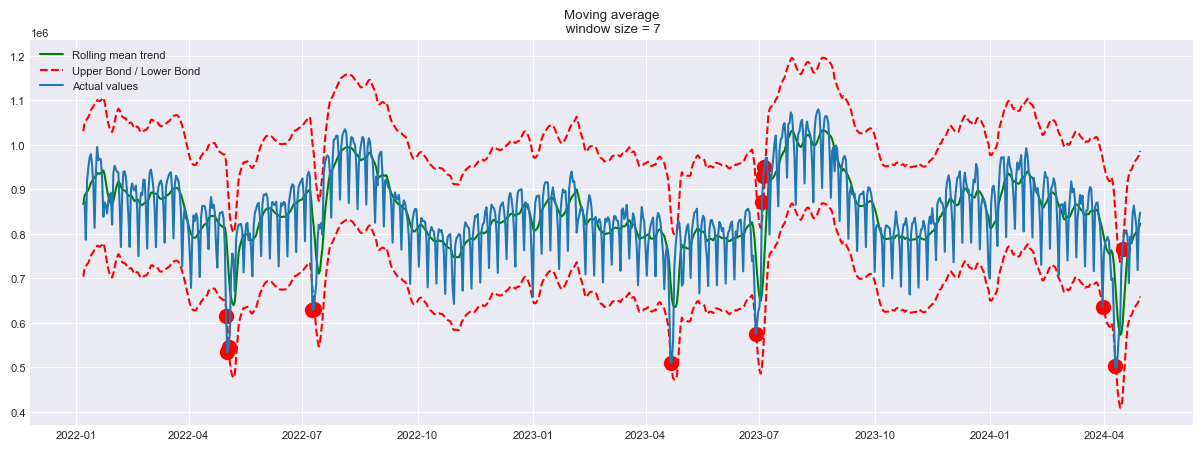

In [19]:
daily_agg_df = df.resample('D').sum()

# plotMovingAverage fonksiyonunu tanımlama
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = series[(series < lower_bond) | (series > upper_bond)]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

# Hareketli ortalama grafiğini çizme
plotMovingAverage(daily_agg_df['Toplam'], window=7, plot_intervals=True, plot_anomalies=True)

 Bazı günlerde meydana gelen yüksek ve düşük enerji üretim miktarları outlier varsayılabilir onun dışında enerji üretim miktarı günlük görünümde belirli bir aralık içinde kaldığı gözlemleniyor.

## Değişkenler arasındaki korelasyon :

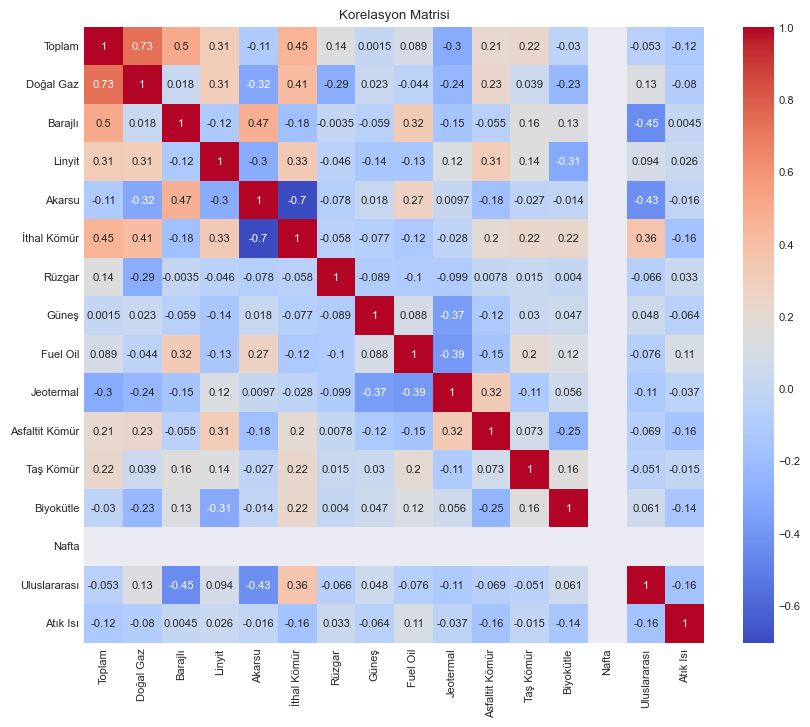

In [20]:
# Korelasyon matrisi
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr().drop(['LNG'],axis=1).drop(['LNG'],axis=0), annot=True, cmap='coolwarm')
plt.title('Korelasyon Matrisi')
plt.show()

#### Korelasyon katsayılarına baktığımızda Toplam üretim ile doğrusal ilişkiler gözlemleniyor. Doğal gaz diğer enerji türlerine göre daha pozitif ayrışmaktadır

# Temel Model Oluşturma


Bir tahmin problemiyle karşılaşıldığında, bir temel model oluşturmak önemlidir. Bu genellikle daha karmaşık modellerin uygulanmaya değer olup olmadığını değerlendirmek için referans olarak kullanılabilecek çok basit bir modeldir.

Skforecast, ForecasterEquivalentDate sınıfı ile kolayca bir temel model oluşturmanıza olanak tanır. Seasonal Naive Forecasting olarak da bilinen bu model, basitçe bir önceki sezonun aynı döneminde gözlemlenen değeri döndürür (örneğin, bir önceki haftanın aynı iş günü, bir önceki günün aynı saati vb.)

Yapılan keşif analizine dayanarak, temel model, her saati bir önceki gündeki aynı saatin değerini kullanarak tahmin eden model olacaktır.

##### Geriye dönük test sürecinin, modelin belirli miktarda veri ile eğitilmesi ve modelin görmediği verilerle tahmin yeteneğinin değerlendirilmesinden oluşuyor

In [21]:
# Önceki günün aynı saatinin değeri
# ==============================================================================
forecaster = ForecasterEquivalentDate(
                 offset    = pd.DateOffset(days=1),
                 n_offsets = 1
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_validation, 'Toplam'])
forecaster

ForecasterEquivalentDate 
Offset: <DateOffset: days=1> 
Number of offsets: 1 
Aggregation function: mean 
Window size: 24 
Training range: [Timestamp('2022-01-01 00:00:00'), Timestamp('2024-03-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Creation date: 2024-06-01 00:52:43 
Last fit date: 2024-06-01 00:52:43 
Skforecast version: 0.12.1 
Python version: 3.9.12 
Forecaster id: None 

In [22]:
# Geriye dönük test
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Toplam'],
                          steps              = 24,
                          metric             = 'mean_absolute_percentage_error',
                          initial_train_size = len(data.loc[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

print(f"Geriye donük test (MAPE): {metric}")

  0%|          | 0/30 [00:00<?, ?it/s]

Geriye donük test (MAPE): 0.07552347691885078


## Yinelemeli çok adımlı tahmin

#### Bir özyinelemeli otoregresif model ForecasterAutoreg, temel regresör olarak bir gradyan artırma regresörü LGBMRegresörü kullanılarak eğitilir. Bir sonraki saatin talebini tahmin etmek için 24 saatlik bir zaman penceresi (24 gecikme) kullanılır. Bu, önceki 24 saatin talep değerlerinin tahmin edici olarak kullanıldığı anlamına gelir. Temel regresörün hiperparametreleri varsayılan değerlerinde bırakılır.

## LightGBM

In [23]:
# forecaster oluşturma
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=2241, verbose=-1),
                 lags      = 24
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_validation, 'Toplam'])
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=2241, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2022-01-01 00:00:00'), Timestamp('2024-03-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 2241, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: 

## Geriye dönük test

Modelin tahmin kabiliyetine ilişkin sağlam bir tahmin elde etmek için bir geriye dönük test süreci gerçekleştirilir. Geriye dönük test süreci, test setindeki her bir gözlem için üretimde yapılanla aynı prosedürü izleyerek bir tahmin üretmekten ve ardından tahmin edilen değeri gerçek değerle karşılaştırmaktan oluşur.

Geriye dönük test işlemi backtesting_forecaster() fonksiyonu kullanılarak uygulanır. Bu kullanım durumu için simülasyon şu şekilde gerçekleştirilir: model 2022-01-01 00:00 ile 2024-03-31 23:00 arasındaki verilerle eğitilir ve ardından her gün 23:59'da sonraki 24 saati tahmin eder. Kullanılan hata ölçütü ortalama mutlak yüzde hatası (MAPE).

In [24]:
# Geriye dönük test
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Toplam'],
                          steps              = 24,
                          metric             = 'mean_absolute_percentage_error',
                          initial_train_size = len(data.loc[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = True,
                          show_progress      = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 19704
Number of observations used for backtesting: 720
    Number of folds: 30
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-01-01 00:00:00 -- 2024-03-31 23:00:00  (n=19704)
    Validation: 2024-04-01 00:00:00 -- 2024-04-01 23:00:00  (n=24)
Fold: 1
    Training:   2022-01-01 00:00:00 -- 2024-03-31 23:00:00  (n=19704)
    Validation: 2024-04-02 00:00:00 -- 2024-04-02 23:00:00  (n=24)
Fold: 2
    Training:   2022-01-01 00:00:00 -- 2024-03-31 23:00:00  (n=19704)
    Validation: 2024-04-03 00:00:00 -- 2024-04-03 23:00:00  (n=24)
Fold: 3
    Training:   2022-01-01 00:00:00 -- 2024-03-31 23:00:00  (n=19704)
    Validation: 2024-04-04 00:00:00 -- 2024-04-04 23:00:00  (n=24)
Fold: 4
    Training:   2022-01-01 00:00:00 -- 2024-03-31 23:00:00  (n=19704)
    Validation: 2024-04-05

  0%|          | 0/30 [00:00<?, ?it/s]

In [25]:
# Plot Tahimn vs Gerçek değer
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Toplam'], name="Gerçek değer", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="Tahmin", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Test verisinde gerçek değerler vs tahmin değerleri",
    xaxis_title="Tarih",
    yaxis_title="Toplam",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.0001,
        xanchor="left",
        x=0.001
    )
)
fig.show()

In [26]:
# Geriye dönük test hatası
# ==============================================================================
LightGBM_metric = (f'LGBMRegressor geriye dönük test hatası (MAPE): {metric}')
LightGBM_metric

'LGBMRegressor geriye dönük test hatası (MAPE): 0.10505689609946657'

## eXtreme Gradient Boosting

In [27]:
# forecaster oluşturma
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=2241),
                 lags      = 24
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_validation, 'Toplam'])
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=2241, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous includ

In [28]:
# Geriye dönük test
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Toplam'],
                          steps              = 24,
                          metric             = 'mean_absolute_percentage_error',
                          initial_train_size = len(data.loc[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = True,
                          show_progress      = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 19704
Number of observations used for backtesting: 720
    Number of folds: 30
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-01-01 00:00:00 -- 2024-03-31 23:00:00  (n=19704)
    Validation: 2024-04-01 00:00:00 -- 2024-04-01 23:00:00  (n=24)
Fold: 1
    Training:   2022-01-01 00:00:00 -- 2024-03-31 23:00:00  (n=19704)
    Validation: 2024-04-02 00:00:00 -- 2024-04-02 23:00:00  (n=24)
Fold: 2
    Training:   2022-01-01 00:00:00 -- 2024-03-31 23:00:00  (n=19704)
    Validation: 2024-04-03 00:00:00 -- 2024-04-03 23:00:00  (n=24)
Fold: 3
    Training:   2022-01-01 00:00:00 -- 2024-03-31 23:00:00  (n=19704)
    Validation: 2024-04-04 00:00:00 -- 2024-04-04 23:00:00  (n=24)
Fold: 4
    Training:   2022-01-01 00:00:00 -- 2024-03-31 23:00:00  (n=19704)
    Validation: 2024-04-05

  0%|          | 0/30 [00:00<?, ?it/s]

In [29]:
# Plot Tahimn vs Gerçek değer
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Toplam'], name="Gerçek değer", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="Tahmin", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Test verisinde gerçek değerler vs tahmin değerleri",
    xaxis_title="Tarih",
    yaxis_title="Toplam",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.0001,
        xanchor="left",
        x=0.001
    )
)
fig.show()

In [30]:
# Geriye dönük test hatası
# ==============================================================================
XGBoost_metric = (f'XGBRegressor geriye dönük test hatası (MAPE): {metric}')
print(XGBoost_metric)

XGBRegressor geriye dönük test hatası (MAPE): 0.10470813482570634


## RandomForest

In [31]:
# forecaster oluşturma
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=2241),
                 lags      = 24
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_validation, 'Toplam'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=5, random_state=2241) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2022-01-01 00:00:00'), Timestamp('2024-03-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 2241, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-06-01 00:52:55 
Last fit

In [32]:
# Geriye dönük test
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Toplam'],
                          steps              = 24,
                          metric             = 'mean_absolute_percentage_error',
                          initial_train_size = len(data.loc[:end_validation]),
                          refit              = True,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

  0%|          | 0/30 [00:00<?, ?it/s]

In [33]:
# Plot Tahimn vs Gerçek değer
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Toplam'], name="Gerçek değer", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="Tahmin", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Test verisinde gerçek değerler vs tahmin değerleri",
    xaxis_title="Tarih",
    yaxis_title="Toplam",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.0001,
        xanchor="left",
        x=0.001
    )
)
fig.show()

In [34]:
# Geriye dönük test hatası
# ==============================================================================
RandomForest_metric = (f'RandomForestRegressor geriye dönük test hatası (MAPE): {metric}')
print(RandomForest_metric)

RandomForestRegressor geriye dönük test hatası (MAPE): 0.11892986845460685


# Hiperparametre ayarlama

## LightGBM optimizasyonu

Eğitilen ForecasterAutoreg nesnesi ilk 24 gecikmeyi ve varsayılan hiperparametrelerle bir LGMBRegressor modelini kullanmıştır. Ancak, bu değerlerin en uygun değerler olması için bir neden yoktur. En iyi hiperparametreleri bulmak için bayesian_search_forecaster() fonksiyonu kullanılarak bir Bayes Araması gerçekleştirilir. Arama, daha önce olduğu gibi aynı geriye dönük test süreci kullanılarak gerçekleştirilir, ancak her seferinde model farklı hiperparametre ve gecikme kombinasyonları ile eğitilir. Hiperparametre aramasının doğrulama seti kullanılarak yapılması gerektiğine dikkat etmek önemlidir, bu nedenle test verileri asla kullanılmaz.

In [35]:
# Hiperparametre araması
# ==============================================================================
forecaster_tuned_lgbm = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=2241, verbose=-1),
                 lags      = 24, 
             )

# Tahminci olarak kullanılan gecikmeler
lags_grid = [24, (1, 2, 3, 23, 24, 25, 47, 48, 49)]

# Regressor hiperparametreleri arama uzayı
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 600, 1200, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'          : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
                                   forecaster         = forecaster_tuned_lgbm,
                                   y                  = data.loc[:end_validation, 'Toplam'],
                                   steps              = 24,
                                   metric             = 'mean_absolute_percentage_error',
                                   search_space       = search_space,
                                   initial_train_size = len(data[:end_train]),
                                   refit              = False,
                                   n_trials           = 20, # Daha kapsamlı arama için arttırılabilir
                                   random_state       = 123,
                                   return_best        = True,
                                   n_jobs             = 'auto',
                                   verbose            = False,
                                   show_progress      = True
                               )

  0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Ahmet\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 3, 23, 24, 25, 47, 48, 49) which is of type tuple.



`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'n_estimators': 800, 'max_depth': 8, 'learning_rate': 0.09942094792221498, 'reg_alpha': 0.1, 'reg_lambda': 0.5}
  Backtesting metric: 0.03728854208251549



In [38]:
# Arama sonuçları
# ==============================================================================
results_search.head(10)

lags  \
2   [1, 2, 3, 23, 24, 25, 47, 48, 49]   
12  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
13  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
14  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
10  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
19  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
9   [1, 2, 3, 23, 24, 25, 47, 48, 49]   
18  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
11  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
0   [1, 2, 3, 23, 24, 25, 47, 48, 49]   

                                               params  \
2   {'n_estimators': 800, 'max_depth': 8, 'learnin...   
12  {'n_estimators': 600, 'max_depth': 10, 'learni...   
13  {'n_estimators': 700, 'max_depth': 9, 'learnin...   
14  {'n_estimators': 700, 'max_depth': 9, 'learnin...   
10  {'n_estimators': 600, 'max_depth': 10, 'learni...   
19  {'n_estimators': 900, 'max_depth': 7, 'learnin...   
9   {'n_estimators': 1000, 'max_depth': 9, 'learni...   
18  {'n_estimators': 900, 'max_depth': 8, 'learnin...   
11  {'n_estimators': 600, 'max_depth': 10, 'learni...   
0   {'n_estimators': 1000, 'max_depth': 5, 'learni...   

    mean_absolute_percentage_error  n_estimators  max_depth  learning_rate  \
2                         0.037289         800.0        8.0       0.099421   
12                        0.038660         600.0       10.0       0.150378   
13                        0.038702         700.0        9.0       0.128334   
14                        0.039334         700.0        9.0       0.128312   
10                        0.040041         600.0       10.0       0.205234   
19                        0.040092         900.0        7.0       0.302306   
9                         0.040105        1000.0        9.0       0.050766   
18                        0.040208         900.0        8.0       0.085158   
11                        0.040242         600.0       10.0       0.228753   
0                         0.041161        1000.0        5.0       0.121157   

    reg_alpha  reg_lambda  
2         0.1         0.5  
12        0.0         1.0  
13        0.2         1.0  
14        0.1         1.0  
10        0.0         0.0  
19        0.3         0.6  
9         0.8         0.2  
18        0.1         0.9  
11        0.0         0.1  
0         0.6         0.7

return_best True olarak ayarlandığından, tahminci nesnesi otomatik olarak bulunan en iyi yapılandırma ile güncellenir ve tüm veri kümesi üzerinde eğitilir. Bu son model daha sonra yeni veriler üzerinde gelecekteki tahminler için kullanılabilir.

In [39]:
# En iyi model
# ==============================================================================
forecaster_tuned_lgbm

ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.09942094792221498, max_depth=8, n_estimators=800,
              random_state=2241, reg_alpha=0.1, reg_lambda=0.5, verbose=-1) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Transformer for y: None 
Transformer for exog: None 
Window size: 49 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2022-01-01 00:00:00'), Timestamp('2024-03-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.09942094792221498, 'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 800, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 2241, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 1.

### Test verileri üzerinde geriye dönük test

Doğrulama verileri kullanılarak en iyi hiperparametre kombinasyonu belirlendikten sonra, test setine uygulandığında modelin tahmin kapasitesi değerlendirilir. Bu, modelin tahmin yeteneğini analiz etmek için tam potansiyelini kullanmaya yardımcı olacaktır.

In [40]:
# Test verileri üzerinde son modelin geriye dönük testi
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster_tuned_lgbm,
                          y                  = data['Toplam'],
                          steps              = 24,
                          metric             = 'mean_absolute_percentage_error',
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False, # Ayrıntılı bilgileri görmek için True olarak değiştir
                          show_progress      = True
                      )


# Geriye dönük test hatası
# ==============================================================================
LightGBM_tuned_metric = (f'Optimize edilmiş LGBMRegressor geriye dönük test hatası (MAPE): {metric}')
LightGBM_tuned_metric

  0%|          | 0/30 [00:00<?, ?it/s]

'Optimize edilmiş LGBMRegressor geriye dönük test hatası (MAPE): 0.07728625877366696'

In [41]:
predictions.head()

pred
2024-04-01 00:00:00  30133.609034
2024-04-01 01:00:00  29239.725439
2024-04-01 02:00:00  28741.736882
2024-04-01 03:00:00  28658.687777
2024-04-01 04:00:00  28798.942460

In [42]:
# Plot Tahimn vs Gerçek değer
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Toplam'], name="Gerçek değer", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="Tahmin", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Test verisinde gerçek değerler vs tahmin değerleri",
    xaxis_title="Tarih",
    yaxis_title="Toplam",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.0001,
        xanchor="left",
        x=0.001
    )
)
fig.show()

## XGBoost optimizasyonu

In [43]:
# Forecaster modelini oluşturma
forecaster_tuned_xgb = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=2241),
                 lags      = 24, # Bu değer grid search'te değiştirilecektir
             )

# Lags used as predictors
lags_grid = [24, (1, 2, 3, 23, 24, 25, 47, 48, 49)]

# Regressor hiperparametreleri arama uzayı
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 600, 1200, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'subsample'     : trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'          : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
                                   forecaster         = forecaster_tuned_xgb,
                                   y                  = data.loc[:end_validation, 'Toplam'],
                                   steps              = 24,
                                   metric             = 'mean_absolute_error',
                                   search_space       = search_space,
                                   initial_train_size = len(data[:end_train]),
                                   refit              = False,
                                   n_trials           = 20, # Daha kapsamlı bir arama için artırabilirsiniz
                                   random_state       = 123,
                                   return_best        = True,
                                   n_jobs             = 'auto',
                                   verbose            = False,
                                   show_progress      = True
                               )

  0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Ahmet\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 3, 23, 24, 25, 47, 48, 49) which is of type tuple.



`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'n_estimators': 1100, 'max_depth': 9, 'learning_rate': 0.011810698434221764, 'subsample': 0.5, 'colsample_bytree': 0.6, 'reg_alpha': 0.8, 'reg_lambda': 0.30000000000000004}
  Backtesting metric: 1316.4733308457287



In [45]:
results_search.iloc[0,1]

{'n_estimators': 1100,
 'max_depth': 9,
 'learning_rate': 0.011810698434221764,
 'subsample': 0.5,
 'colsample_bytree': 0.6,
 'reg_alpha': 0.8,
 'reg_lambda': 0.30000000000000004}

In [46]:
# Arama sonuçları
# ==============================================================================
results_search.head(10)

lags  \
13  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
15  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
10  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
7   [1, 2, 3, 23, 24, 25, 47, 48, 49]   
18  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
11  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
16  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
9   [1, 2, 3, 23, 24, 25, 47, 48, 49]   
12  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
6   [1, 2, 3, 23, 24, 25, 47, 48, 49]   

                                               params  mean_absolute_error  \
13  {'n_estimators': 1100, 'max_depth': 9, 'learni...          1316.473331   
15  {'n_estimators': 1100, 'max_depth': 9, 'learni...          1334.115769   
10  {'n_estimators': 1200, 'max_depth': 10, 'learn...          1346.285297   
7   {'n_estimators': 1000, 'max_depth': 9, 'learni...          1359.261901   
18  {'n_estimators': 1100, 'max_depth': 9, 'learni...          1381.094746   
11  {'n_estimators': 1200, 'max_depth': 10, 'learn...          1393.782894   
16  {'n_estimators': 1100, 'max_depth': 8, 'learni...          1401.907694   
9   {'n_estimators': 1000, 'max_depth': 7, 'learni...          1432.123713   
12  {'n_estimators': 1200, 'max_depth': 9, 'learni...          1435.339078   
6   {'n_estimators': 800, 'max_depth': 5, 'learnin...          1439.880209   

    n_estimators  max_depth  learning_rate  subsample  colsample_bytree  \
13        1100.0        9.0       0.011811        0.5               0.6   
15        1100.0        9.0       0.015123        0.6               0.5   
10        1200.0       10.0       0.033211        0.6               0.5   
7         1000.0        9.0       0.050766        0.9               0.6   
18        1100.0        9.0       0.014948        0.6               0.5   
11        1200.0       10.0       0.061408        0.6               0.5   
16        1100.0        8.0       0.096111        0.5               0.7   
9         1000.0        7.0       0.200586        1.0               1.0   
12        1200.0        9.0       0.122744        0.6               0.6   
6          800.0        5.0       0.214341        0.9               1.0   

    reg_alpha  reg_lambda  
13        0.8         0.3  
15        0.7         0.3  
10        0.9         0.5  
7         0.2         0.6  
18        0.6         0.0  
11        1.0         0.4  
16        0.7         0.3  
9         0.3         0.0  
12        0.9         0.6  
6         0.5         0.7

In [47]:
# En iyi model
# ==============================================================================
forecaster_tuned_xgb

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.011810698434221764,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=2241, ...) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Transformer for y: None 
Transformer for exog: None 
Window size: 49 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous va

### Test verileri üzerinde geriye dönük test

In [48]:
# Test verileri üzerinde son modelin geriye dönük testi
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster_tuned_xgb,
                          y                  = data['Toplam'],
                          steps              = 24,
                          metric             = 'mean_absolute_percentage_error',
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False, # Ayrıntılı bilgileri görmek için True olarak değiştir
                          show_progress      = True
                      )


# Geriye dönük test hatası
# ==============================================================================
XGBoost_tuned_metric = (f'Optimize edilmiş XGBRegressor geriye dönük test hatası (MAPE): {metric}')
XGBoost_tuned_metric

  0%|          | 0/30 [00:00<?, ?it/s]

'Optimize edilmiş XGBRegressor geriye dönük test hatası (MAPE): 0.0765900784910265'

In [49]:
predictions.head()

pred
2024-04-01 00:00:00  30330.771484
2024-04-01 01:00:00  29283.724609
2024-04-01 02:00:00  28730.560547
2024-04-01 03:00:00  28917.626953
2024-04-01 04:00:00  29264.921875

In [50]:
# Plot Tahimn vs Gerçek değer
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Toplam'], name="Gerçek değer", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="Tahmin", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Test verisinde gerçek değerler vs tahmin değerleri",
    xaxis_title="Tarih",
    yaxis_title="Toplam",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.0001,
        xanchor="left",
        x=0.001
    )
)
fig.show()

## RandomForest Optimizasyonu

In [52]:
# RandomForestRegressor modelini tanımlayın
forecaster_tuned_rf = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=2241),
    lags=24,  # Bu değer grid search sırasında değiştirilecek
)

# Tahminci olarak kullanılan gecikmeler
lags_grid = [24, (1, 2, 3, 23, 24, 25, 47, 48, 49)]

# Regressor hiperparametreleri arama uzayı
def search_space(trial):
    search_space = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 20, step=1),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10, step=1),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4, step=1),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'lags': trial.suggest_categorical('lags', lags_grid)
    }
    return search_space

# Bayesian search ile hyperparameter tuning işlemi
results_search, frozen_trial = bayesian_search_forecaster(
    forecaster=forecaster_tuned_rf,
    y=data.loc[:end_validation, 'Toplam'],
    steps=24,
    metric='mean_absolute_percentage_error',
    search_space=search_space,
    initial_train_size=len(data[:end_train]),
    refit=False,
    n_trials=20,  # Daha kapsamlı arama için arttırılabilir
    random_state=123,
    return_best=True,
    n_jobs='auto',
    verbose=False,
    show_progress=True
)

  0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Ahmet\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

c:\Users\Ahmet\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

c:\Users\Ahmet\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors a

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'n_estimators': 800, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}
  Backtesting metric: 0.04111815907946198



In [63]:
results_search.iloc[0,1]

{'n_estimators': 800,
 'max_depth': 18,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_features': 'log2'}

In [53]:
# Test verileri üzerinde son modelin geriye dönük testi
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster_tuned_rf,
    y                  = data['Toplam'],
    steps              = 24,
    metric             = 'mean_absolute_percentage_error',
    initial_train_size = len(data[:end_validation]),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,  # Ayrıntılı bilgileri görmek için True olarak değiştir
    show_progress      = True
)

# Geriye dönük test hatası
# ==============================================================================
RF_tuned_metric = f'Optimize edilmiş RandomForestRegressor geriye dönük test hatası (MAPE): {metric}'
print(RF_tuned_metric)

  0%|          | 0/30 [00:00<?, ?it/s]

Optimize edilmiş RandomForestRegressor geriye dönük test hatası (MAPE): 0.08861472435580314


In [54]:
predictions.head()

pred
2024-04-01 00:00:00  30752.252810
2024-04-01 01:00:00  30044.975329
2024-04-01 02:00:00  29496.494542
2024-04-01 03:00:00  29651.545565
2024-04-01 04:00:00  29971.756777

In [55]:
# Plot Tahimn vs Gerçek değer
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Toplam'], name="Gerçek değer", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="Tahmin", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Test verisinde gerçek değerler vs tahmin değerleri",
    xaxis_title="Tarih",
    yaxis_title="Toplam",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.0001,
        xanchor="left",
        x=0.001
    )
)
fig.show()

Optimize edilmiş LGBM ve XGB (MAPE) değerleri birbirine çok yakın. Ayrıca ilk başta RandomForest modeli öbür iki modele göre kötü sonuç verse bile optimize edildikten sonra MAPE değeri öbür modellere baya yaklaşmıştır.

# Dışsal değişkenlerle tahmin

Şimdiye kadar, zaman serilerinin sadece gecikmeli değerleri tahmin edici olarak kullanılmıştır. Ancak, başka değişkenleri de tahmin edici olarak dahil etmek mümkündür. Bu değişkenler dışsal değişkenler (özellikler) olarak bilinir ve bunların kullanımı modelin tahmin kapasitesini artırabilir.

Dışsal değişkenlerin yaygın örnekleri haftanın günü, ay, yıl veya tatiller gibi takvimden türetilen değişkenlerdir. Sıcaklık, nem ve rüzgar gibi hava durumu değişkenleri de enflasyon ve faiz oranları gibi ekonomik değişkenler gibi bu kategoriye girer

## Feature Engineering

In [56]:
# Calendar features
# ==============================================================================
calendar_features = pd.DataFrame(index=data.index)
calendar_features['Saat'] = calendar_features.index.hour
calendar_features['Gün'] = calendar_features.index.day
calendar_features['Ay'] = calendar_features.index.month
calendar_features['Yıl'] = calendar_features.index.year
calendar_features['yılın_haftaları'] = calendar_features.index.isocalendar().week
calendar_features['hafta_günü'] = calendar_features.index.day_of_week + 1
calendar_features['gün_saati'] = calendar_features.index.hour + 1



# Lag ve Rolling özellikleri
Toplam_features = data[['Toplam']].copy()
Toplam_features['Toplam_roll_mean_1_day'] = Toplam_features['Toplam'].rolling(24, closed='left').mean()
Toplam_features['Toplam_roll_mean_7_day'] = Toplam_features['Toplam'].rolling(24*7, closed='left').mean()
Toplam_features['Toplam_roll_max_1_day'] = Toplam_features['Toplam'].rolling(24, closed='left').max()
Toplam_features['Toplam_roll_min_1_day'] = Toplam_features['Toplam'].rolling(24, closed='left').min()
Toplam_features['Toplam_roll_max_7_day'] = Toplam_features['Toplam'].rolling(24*7, closed='left').max()
Toplam_features['Toplam_lag_1'] = Toplam_features['Toplam'].shift(1)
Toplam_features['Toplam_lag_2'] = Toplam_features['Toplam'].shift(2)
Toplam_features['Toplam_lag_3'] = Toplam_features['Toplam'].shift(3)
Toplam_features['Toplam_lag_24'] = Toplam_features['Toplam'].shift(24)
Toplam_features['Toplam_lag_168'] = Toplam_features['Toplam'].shift(168)

# Dışsal özellikleri birleştirme
# ==============================================================================
exogenous_features = pd.concat([
                         calendar_features,
                         Toplam_features,
                     ], axis=1)

# Mevsim özellikleri
def get_season(month):
    if month in [12, 1, 2]:
        return 'Kış'
    elif month in [3, 4, 5]:
        return 'İlk_Bahar'
    elif month in [6, 7, 8]:
        return 'Yaz'
    else:
        return 'Son_Bahar'

exogenous_features['Mevsim'] = calendar_features['Ay'].apply(get_season)
exogenous_features = pd.get_dummies(exogenous_features, columns=['Mevsim'], drop_first=True)
exogenous_features.drop(columns=["Toplam"], inplace=True)

exogenous_features.head()

Saat  Gün  Ay   Yıl  yılın_haftaları  hafta_günü  \
Tarih                                                                   
2022-01-01 00:00:00     0    1   1  2022               52           6   
2022-01-01 01:00:00     1    1   1  2022               52           6   
2022-01-01 02:00:00     2    1   1  2022               52           6   
2022-01-01 03:00:00     3    1   1  2022               52           6   
2022-01-01 04:00:00     4    1   1  2022               52           6   

                     gün_saati  Toplam_roll_mean_1_day  \
Tarih                                                    
2022-01-01 00:00:00          1                     NaN   
2022-01-01 01:00:00          2                     NaN   
2022-01-01 02:00:00          3                     NaN   
2022-01-01 03:00:00          4                     NaN   
2022-01-01 04:00:00          5                     NaN   

                     Toplam_roll_mean_7_day  Toplam_roll_max_1_day  \
Tarih                                                                
2022-01-01 00:00:00                     NaN                    NaN   
2022-01-01 01:00:00                     NaN                    NaN   
2022-01-01 02:00:00                     NaN                    NaN   
2022-01-01 03:00:00                     NaN                    NaN   
2022-01-01 04:00:00                     NaN                    NaN   

                     Toplam_roll_min_1_day  Toplam_roll_max_7_day  \
Tarih                                                               
2022-01-01 00:00:00                    NaN                    NaN   
2022-01-01 01:00:00                    NaN                    NaN   
2022-01-01 02:00:00                    NaN                    NaN   
2022-01-01 03:00:00                    NaN                    NaN   
2022-01-01 04:00:00                    NaN                    NaN   

                     Toplam_lag_1  Toplam_lag_2  Toplam_lag_3  Toplam_lag_24  \
Tarih                                                                          
2022-01-01 00:00:00           NaN           NaN           NaN            NaN   
2022-01-01 01:00:00      30983.59           NaN           NaN            NaN   
2022-01-01 02:00:00      29672.68      30983.59           NaN            NaN   
2022-01-01 03:00:00      28282.42      29672.68      30983.59            NaN   
2022-01-01 04:00:00      27135.73      28282.42      29672.68            NaN   

                     Toplam_lag_168  Mevsim_Son_Bahar  Mevsim_Yaz  \
Tarih                                                               
2022-01-01 00:00:00             NaN                 0           0   
2022-01-01 01:00:00             NaN                 0           0   
2022-01-01 02:00:00             NaN                 0           0   
2022-01-01 03:00:00             NaN                 0           0   
2022-01-01 04:00:00             NaN                 0           0   

                     Mevsim_İlk_Bahar  
Tarih                                  
2022-01-01 00:00:00                 0  
2022-01-01 01:00:00                 0  
2022-01-01 02:00:00                 0  
2022-01-01 03:00:00                 0  
2022-01-01 04:00:00                 0

Takvimin saatler veya günler gibi belirli yönleri döngüseldir. Örneğin, saat-gün döngüsü 0 ila 23 saat arasında değişir. Sürekli bir değişken olarak yorumlanmasına rağmen, 23:00 saati 00:00'dan yalnızca bir saat uzaklıktadır. Aynı durum ay-yıl döngüsü için de geçerlidir, çünkü Aralık ayı Ocak ayından yalnızca bir ay uzaktadır. Sinüs ve kosinüs dönüşümleri gibi trigonometrik fonksiyonların kullanılması, döngüsel modellerin temsil edilmesini ve veri temsilindeki tutarsızlıkların önlenmesini mümkün kılar. Bu yaklaşım döngüsel kodlama olarak bilinir ve modellerin tahmin kabiliyetini önemli ölçüde artırabilir.

In [58]:
# ==============================================================================
def encoding(data: pd.Series, cycle_length: int) -> pd.DataFrame:
    sin = np.sin(2 * np.pi * data/cycle_length)
    cos = np.cos(2 * np.pi * data/cycle_length)
    result =  pd.DataFrame({
                  f"{data.name}_sin": sin,
                  f"{data.name}_cos": cos
              })

    return result


saat_encoded = encoding(exogenous_features['Saat'], cycle_length=24)
gün_encoded = encoding(exogenous_features['Gün'], cycle_length=30)
ay_encoded = encoding(exogenous_features['Ay'], cycle_length=12)
yıl_encoded = encoding(exogenous_features['Yıl'], cycle_length=1)
yılın_haftaları_encoded = encoding(exogenous_features['yılın_haftaları'], cycle_length=52)
haftanın_günü_encoded = encoding(exogenous_features['hafta_günü'], cycle_length=7)
gün_saati_encoded = encoding(exogenous_features['gün_saati'], cycle_length=24)

encoded_features = pd.concat([
                        saat_encoded,
                        gün_encoded,
                        ay_encoded,
                        yıl_encoded,
                        yılın_haftaları_encoded,
                        haftanın_günü_encoded,
                        gün_saati_encoded
                    ], axis=1)

exogenous_features = pd.concat([exogenous_features, encoded_features], axis=1)
exogenous_features.head()

Saat  Gün  Ay   Yıl  yılın_haftaları  hafta_günü  \
Tarih                                                                   
2022-01-01 00:00:00     0    1   1  2022               52           6   
2022-01-01 01:00:00     1    1   1  2022               52           6   
2022-01-01 02:00:00     2    1   1  2022               52           6   
2022-01-01 03:00:00     3    1   1  2022               52           6   
2022-01-01 04:00:00     4    1   1  2022               52           6   

                     gün_saati  Toplam_roll_mean_1_day  \
Tarih                                                    
2022-01-01 00:00:00          1                     NaN   
2022-01-01 01:00:00          2                     NaN   
2022-01-01 02:00:00          3                     NaN   
2022-01-01 03:00:00          4                     NaN   
2022-01-01 04:00:00          5                     NaN   

                     Toplam_roll_mean_7_day  Toplam_roll_max_1_day  ...  \
Tarih                                                               ...   
2022-01-01 00:00:00                     NaN                    NaN  ...   
2022-01-01 01:00:00                     NaN                    NaN  ...   
2022-01-01 02:00:00                     NaN                    NaN  ...   
2022-01-01 03:00:00                     NaN                    NaN  ...   
2022-01-01 04:00:00                     NaN                    NaN  ...   

                     Ay_sin    Ay_cos       Yıl_sin  Yıl_cos  \
Tarih                                                          
2022-01-01 00:00:00     0.5  0.866025 -1.305266e-12      1.0   
2022-01-01 01:00:00     0.5  0.866025 -1.305266e-12      1.0   
2022-01-01 02:00:00     0.5  0.866025 -1.305266e-12      1.0   
2022-01-01 03:00:00     0.5  0.866025 -1.305266e-12      1.0   
2022-01-01 04:00:00     0.5  0.866025 -1.305266e-12      1.0   

                     yılın_haftaları_sin  yılın_haftaları_cos  hafta_günü_sin  \
Tarih                                                                           
2022-01-01 00:00:00                  0.0                  1.0       -0.781831   
2022-01-01 01:00:00                  0.0                  1.0       -0.781831   
2022-01-01 02:00:00                  0.0                  1.0       -0.781831   
2022-01-01 03:00:00                  0.0                  1.0       -0.781831   
2022-01-01 04:00:00                  0.0                  1.0       -0.781831   

                     hafta_günü_cos  gün_saati_sin  gün_saati_cos  
Tarih                                                              
2022-01-01 00:00:00         0.62349       0.258819       0.965926  
2022-01-01 01:00:00         0.62349       0.500000       0.866025  
2022-01-01 02:00:00         0.62349       0.707107       0.707107  
2022-01-01 03:00:00         0.62349       0.866025       0.500000  
2022-01-01 04:00:00         0.62349       0.965926       0.258819  

[5 rows x 34 columns]

#### Birçok durumda, dışsal değişkenler izole değildir. Aksine, hedef değişken üzerindeki etkileri diğer değişkenlerin değerine bağlıdır. Örneğin, güneşin güneş enerjisi üretimi üzerindeki etkisi günün saatine bağlıdır. Dışsal değişkenler arasındaki etkileşim, mevcut değişkenlerin birlikte çarpılmasıyla elde edilen yeni değişkenler tarafından yakalanabilir. Bu etkileşimler scikit-learn'in PolynomialFeatures sınıfı ile kolayca elde edilebilir.

In [59]:
#  Dışsal değişkenler arasındaki etkileşim
# ==============================================================================
transformer_poly = PolynomialFeatures(
                       degree           = 2,
                       interaction_only = True,
                       include_bias     = False
                   ).set_output(transform="pandas")

poly_cols = [col for col in exogenous_features.columns]

poly_features = transformer_poly.fit_transform(exogenous_features[poly_cols].dropna())
poly_features = poly_features.drop(columns=poly_cols)
poly_features.columns = [f"poly_{col}" for col in poly_features.columns]
poly_features.columns = poly_features.columns.str.replace(" ", "__")
exogenous_features = pd.concat([exogenous_features, poly_features], axis=1)
exogenous_features.head(4)

Saat  Gün  Ay   Yıl  yılın_haftaları  hafta_günü  \
Tarih                                                                   
2022-01-01 00:00:00     0    1   1  2022               52           6   
2022-01-01 01:00:00     1    1   1  2022               52           6   
2022-01-01 02:00:00     2    1   1  2022               52           6   
2022-01-01 03:00:00     3    1   1  2022               52           6   

                     gün_saati  Toplam_roll_mean_1_day  \
Tarih                                                    
2022-01-01 00:00:00          1                     NaN   
2022-01-01 01:00:00          2                     NaN   
2022-01-01 02:00:00          3                     NaN   
2022-01-01 03:00:00          4                     NaN   

                     Toplam_roll_mean_7_day  Toplam_roll_max_1_day  ...  \
Tarih                                                               ...   
2022-01-01 00:00:00                     NaN                    NaN  ...   
2022-01-01 01:00:00                     NaN                    NaN  ...   
2022-01-01 02:00:00                     NaN                    NaN  ...   
2022-01-01 03:00:00                     NaN                    NaN  ...   

                     poly_yılın_haftaları_cos__hafta_günü_sin  \
Tarih                                                           
2022-01-01 00:00:00                                       NaN   
2022-01-01 01:00:00                                       NaN   
2022-01-01 02:00:00                                       NaN   
2022-01-01 03:00:00                                       NaN   

                     poly_yılın_haftaları_cos__hafta_günü_cos  \
Tarih                                                           
2022-01-01 00:00:00                                       NaN   
2022-01-01 01:00:00                                       NaN   
2022-01-01 02:00:00                                       NaN   
2022-01-01 03:00:00                                       NaN   

                     poly_yılın_haftaları_cos__gün_saati_sin  \
Tarih                                                          
2022-01-01 00:00:00                                      NaN   
2022-01-01 01:00:00                                      NaN   
2022-01-01 02:00:00                                      NaN   
2022-01-01 03:00:00                                      NaN   

                     poly_yılın_haftaları_cos__gün_saati_cos  \
Tarih                                                          
2022-01-01 00:00:00                                      NaN   
2022-01-01 01:00:00                                      NaN   
2022-01-01 02:00:00                                      NaN   
2022-01-01 03:00:00                                      NaN   

                     poly_hafta_günü_sin__hafta_günü_cos  \
Tarih                                                      
2022-01-01 00:00:00                                  NaN   
2022-01-01 01:00:00                                  NaN   
2022-01-01 02:00:00                                  NaN   
2022-01-01 03:00:00                                  NaN   

                     poly_hafta_günü_sin__gün_saati_sin  \
Tarih                                                     
2022-01-01 00:00:00                                 NaN   
2022-01-01 01:00:00                                 NaN   
2022-01-01 02:00:00                                 NaN   
2022-01-01 03:00:00                                 NaN   

                     poly_hafta_günü_sin__gün_saati_cos  \
Tarih                                                     
2022-01-01 00:00:00                                 NaN   
2022-01-01 01:00:00                                 NaN   
2022-01-01 02:00:00                                 NaN   
2022-01-01 03:00:00                                 NaN   

                     poly_hafta_günü_cos__gün_saati_sin  \
Tarih                                                     
2022-01-01 00:00:00                      

In [60]:
exogenous_features.shape

(20424, 595)

In [61]:
# Select exogenous variables to be included in the model
# ==============================================================================
exog_features = [col for col in exogenous_features.columns]

In [62]:
data = data[['Toplam']].merge(
           exogenous_features[exog_features],
           left_index=True,
           right_index=True,
           how='left'
       )

# Hareketli ortalamaların ve lagların oluşturulması nedeniyle, başlangıçta eksik değerler vardır
data = data.dropna()
data = data.astype('float32')

# Split data into train-val-test
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2022-01-08 00:00:00 --- 2023-08-15 23:00:00  (n=14040)
Validation dates : 2023-08-16 00:00:00 --- 2024-03-31 23:00:00  (n=5496)
Test dates       : 2024-04-01 00:00:00 --- 2024-04-30 23:00:00  (n=720)


Önceki kısımda optimum olarak belirlenen hiperparametreler ve gecikmeler modeli eğitmek için tekrar kullanılır, ancak bu kez dışsal değişkenler de tahmin edici olarak dahil edilir.

### Optimize edilmiş LightGBM modeline dışsal özelliklerin eklenmesi  :

In [64]:
# forecaster oluşturma
# ==============================================================================
lgbm_params = {
    'n_estimators': 800,
    'max_depth': 8,
    'learning_rate': 0.09942094792221498,
    'reg_alpha': 0.1,
    'reg_lambda': 0.5,
    'random_state': 2241,
    'verbose': -1
}
forecaster_tuned_lgbm_exog = ForecasterAutoreg(
                 regressor = LGBMRegressor(**lgbm_params),
                 lags      = 24
             )

In [65]:
# Geriye dönük test modeli
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster_tuned_lgbm_exog,
                          y                  = data['Toplam'],
                          exog               = data[exog_features],
                          steps              = 24,
                          metric             = 'mean_absolute_percentage_error',
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

forecaster_tuned_lgbm_exog_metric = (f"Optimize edilmiş LightGBM w/exog_features MAPE: {metric}")
print(forecaster_tuned_lgbm_exog_metric)
predictions.head()

  0%|          | 0/30 [00:00<?, ?it/s]

Optimize edilmiş LightGBM w/exog_features MAPE: 0.02922029447997849


pred
2024-04-01 00:00:00  30019.814708
2024-04-01 01:00:00  28702.122906
2024-04-01 02:00:00  27997.983944
2024-04-01 03:00:00  28055.398579
2024-04-01 04:00:00  28779.249314

In [66]:
# Plot Tahimn vs Gerçek değer
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Toplam'], name="Gerçek değer", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="Tahmin", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Test verisinde gerçek değerler vs tahmin değerleri",
    xaxis_title="Tarih",
    yaxis_title="Toplam",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.0001,
        xanchor="left",
        x=0.001
    )
)
fig.show()

### Optimize edilmiş XGBoost modeline dışsal özelliklerin eklenmesi  :

In [67]:
# forecaster oluşturma
# ==============================================================================
xgb_params = {
    'n_estimators': 1100,
    'max_depth': 9,
    'learning_rate': 0.011810698434221764,
    'subsample': 0.5,
    'colsample_bytree': 0.6,
    'reg_alpha': 0.8,
    'reg_lambda': 0.30000000000000004
 }
forecaster_tuned_xgb_exog = ForecasterAutoreg(
                 regressor = XGBRegressor(**xgb_params),
                 lags      = 24
             )

In [68]:
# Geriye dönük test modeli
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster_tuned_xgb_exog,
                          y                  = data['Toplam'],
                          exog               = data[exog_features],
                          steps              = 24,
                          metric             = 'mean_absolute_percentage_error',
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

forecaster_tuned_xgb_exog_metric = (f"Optimize edilmiş XGBoost w/exog_features MAPE: {metric}")
print(forecaster_tuned_xgb_exog_metric)
predictions.head()

c:\Users\Ahmet\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



  0%|          | 0/30 [00:00<?, ?it/s]

Optimize edilmiş XGBoost w/exog_features MAPE: 0.022481631462155056


pred
2024-04-01 00:00:00  30274.558594
2024-04-01 01:00:00  29291.625000
2024-04-01 02:00:00  28582.132812
2024-04-01 03:00:00  28396.017578
2024-04-01 04:00:00  28850.326172

In [69]:
# Plot Tahimn vs Gerçek değer
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Toplam'], name="Gerçek değer", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="Tahmin", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Test verisinde gerçek değerler vs tahmin değerleri",
    xaxis_title="Tarih",
    yaxis_title="Toplam",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.0001,
        xanchor="left",
        x=0.001
    )
)
fig.show()

### Optimize edilmiş RandomForest modeline dışsal özelliklerin eklenmesi  :

In [70]:
# forecaster oluşturma
# ==============================================================================
rf_params = {
    'n_estimators': 800,
    'max_depth': 18,
    'min_samples_split': 3,
    'min_samples_leaf': 1,
    'max_features': 'log2'
    }
forecaster_tuned_rf_exog = ForecasterAutoreg(
                 regressor = RandomForestRegressor(**rf_params),
                 lags      = 24
             )

In [72]:
# Geriye dönük test
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster_tuned_rf_exog,
                          y                  = data['Toplam'],
                          exog               = data[exog_features],
                          steps              = 24,
                          metric             = 'mean_absolute_percentage_error',
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

forecaster_tuned_rf_exog_metric = (f"Optimize edilmiş RandomForest w/exog_features MAPE: {metric}")
print(forecaster_tuned_rf_exog_metric)
predictions.head()


c:\Users\Ahmet\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



  0%|          | 0/30 [00:00<?, ?it/s]

Optimize edilmiş RandomForest w/exog_features MAPE: 0.030943234125780487


pred
2024-04-01 00:00:00  29723.132836
2024-04-01 01:00:00  28953.410415
2024-04-01 02:00:00  27995.327291
2024-04-01 03:00:00  27584.413421
2024-04-01 04:00:00  27435.598437

In [73]:
# Plot Tahimn vs Gerçek değer
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Toplam'], name="Gerçek değer", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="Tahmin", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Test verisinde gerçek değerler vs tahmin değerleri",
    xaxis_title="Tarih",
    yaxis_title="Toplam",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.0001,
        xanchor="left",
        x=0.001
    )
)
fig.show()

# SHAP

SHAP (SHapley Additive exPlanations) değerleri, değişkenlerin ve değerlerin tahminleri görsel ve niceliksel olarak nasıl etkilediğini anlamaya yardımcı olduğundan, makine öğrenimi modellerini açıklamak için popüler bir yöntemdir.

In [76]:
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(
                       y    = data_train['Toplam'],
                       exog = data_train[exog_features]
                   )

display(X_train.head(3))
display(y_train.head(3))

lag_1         lag_2         lag_3         lag_4  \
Tarih                                                                         
2022-01-09 00:00:00  35822.210938  37558.308594  38538.300781  39525.210938   
2022-01-09 01:00:00  33420.140625  35822.210938  37558.308594  38538.300781   
2022-01-09 02:00:00  32008.859375  33420.140625  35822.210938  37558.308594   

                            lag_5         lag_6         lag_7         lag_8  \
Tarih                                                                         
2022-01-09 00:00:00  40515.839844  41401.410156  39998.140625  38505.968750   
2022-01-09 01:00:00  39525.210938  40515.839844  41401.410156  39998.140625   
2022-01-09 02:00:00  38538.300781  39525.210938  40515.839844  41401.410156   

                            lag_9        lag_10  ...  \
Tarih                                            ...   
2022-01-09 00:00:00  37804.531250  37767.269531  ...   
2022-01-09 01:00:00  38505.968750  37804.531250  ...   
2022-01-09 02:00:00  39998.140625  38505.968750  ...   

                     poly_yılın_haftaları_cos__hafta_günü_sin  \
Tarih                                                           
2022-01-09 00:00:00                             -2.431436e-16   
2022-01-09 01:00:00                             -2.431436e-16   
2022-01-09 02:00:00                             -2.431436e-16   

                     poly_yılın_haftaları_cos__hafta_günü_cos  \
Tarih                                                           
2022-01-09 00:00:00                                  0.992709   
2022-01-09 01:00:00                                  0.992709   
2022-01-09 02:00:00                                  0.992709   

                     poly_yılın_haftaları_cos__gün_saati_sin  \
Tarih                                                          
2022-01-09 00:00:00                                 0.256932   
2022-01-09 01:00:00                                 0.496354   
2022-01-09 02:00:00                                 0.701951   

                     poly_yılın_haftaları_cos__gün_saati_cos  \
Tarih                                                          
2022-01-09 00:00:00                                 0.958883   
2022-01-09 01:00:00                                 0.859711   
2022-01-09 02:00:00                                 0.701951   

                     poly_hafta_günü_sin__hafta_günü_cos  \
Tarih                                                      
2022-01-09 00:00:00                        -2.449294e-16   
2022-01-09 01:00:00                        -2.449294e-16   
2022-01-09 02:00:00                        -2.449294e-16   

                     poly_hafta_günü_sin__gün_saati_sin  \
Tarih                                                     
2022-01-09 00:00:00                       -6.339238e-17   
2022-01-09 01:00:00                       -1.224647e-16   
2022-01-09 02:00:00                       -1.731912e-16   

                     poly_hafta_günü_sin__gün_saati_cos  \
Tarih                                                     
2022-01-09 00:00:00                       -2.365836e-16   
2022-01-09 01:00:00                       -2.121150e-16   
2022-01-09 02:00:00                       -1.731912e-16   

                     poly_hafta_günü_cos__gün_saati_sin  \
Tarih                                                     
2022-01-09 00:00:00                            0.258819   
2022-01-09 01:00:00                            0.500000   
2022-01-09 02:00:00                            0.707107   

                     poly_hafta_günü_cos__gün_saati_cos  \
Tarih                                                     
2022-01-09 00:00:00                            0.965926   
2022-01-09 01:00:00                            0.866025   
2022-01-09 02:00:00                            0.707107   

                     poly_gün_saati_sin__gün_saati_cos  
Tarih                                                   
2022-01-09 00:00:00                           0.250000  
2022-

Tarih
2022-01-09 00:00:00    33420.140625
2022-01-09 01:00:00    32008.859375
2022-01-09 02:00:00    30609.589844
Freq: H, Name: y, dtype: float32

### CatBoost ve SHAP ile özellik seçimi

In [77]:

from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, Pool
import shap
# Hedef ve özellikleri belirleyin
target = 'Toplam'
features = data.columns.drop(target)

# SHAP değerlerine göre özellik seçimi yapma
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
important_features_all_folds = []

for train_index, val_index in kf.split(data):
    Xs_train, Xs_val = data.iloc[train_index][features], data.iloc[val_index][features]
    ys_train, ys_val = data.iloc[train_index][target], data.iloc[val_index][target]
    
    # CatBoost modelini eğit
    model = CatBoostRegressor(verbose=0)
    model.fit(Xs_train, ys_train)
    
    # SHAP değerlerini hesapla
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(Xs_val)
    
    # SHAP değerlerinin ortalamasını al
    mean_shap_values = np.abs(shap_values).mean(axis=0)
    
    # SHAP değerlerine göre özelliklerin önem derecesini hesapla
    shap_importance = pd.DataFrame({
        'feature': features,
        'importance': mean_shap_values
    }).sort_values(by='importance', ascending=False)
    
    # En önemli özellikleri belirle
    important_features = shap_importance[shap_importance['importance'] > np.percentile(mean_shap_values, 75)]['feature'].tolist()
    important_features_all_folds.append(important_features)

# Bütün foldlarda önemli olarak görülen özelliklerin ortak setini bulun
important_features_set = set(important_features_all_folds[0])
for features in important_features_all_folds[1:]:
    important_features_set.intersection_update(features)

selected_features = list(important_features_set)


<frozen importlib._bootstrap>:228: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject



In [115]:
# Sonucu göster
print("Bütün foldlarda önemli olarak görülen özellikler:", selected_features)
# Seçilen özelliklerin sayısını göster
print(f"Seçilen özelliklerin sayısı: {len(selected_features)}")
# Seçilmeden önce toplam özellik
print(f"Seçilmeden önce toplam özellik: {len(exog_features)}")
#[1, 2, 4, 6, 19, 21, 23]

Bütün foldlarda önemli olarak görülen özellikler: ['poly_Toplam_lag_1__Toplam_lag_168', 'poly_Saat__Ay', 'poly_Yıl__Toplam_lag_1', 'poly_Saat_sin__Ay_cos', 'poly_Toplam_roll_min_1_day__Toplam_lag_1', 'poly_Yıl__gün_saati_sin', 'poly_yılın_haftaları_cos__gün_saati_sin', 'poly_hafta_günü__gün_saati_cos', 'poly_gün_saati_sin__gün_saati_cos', 'poly_hafta_günü__Toplam_lag_168', 'poly_Toplam_lag_1__gün_saati_cos', 'poly_Saat__Saat_cos', 'poly_Saat_sin__Saat_cos', 'poly_Ay_cos__gün_saati_cos', 'poly_Toplam_lag_2__Toplam_lag_24', 'poly_Saat__Yıl_sin', 'poly_yılın_haftaları__hafta_günü_cos', 'poly_Toplam_lag_3__Toplam_lag_24', 'poly_gün_saati__gün_saati_cos', 'poly_Yıl_sin__gün_saati_sin', 'poly_Toplam_lag_1__Mevsim_Yaz', 'poly_Saat_sin__Yıl_cos', 'poly_hafta_günü__Saat_sin', 'poly_Toplam_roll_max_1_day__Toplam_lag_1', 'Toplam_lag_168', 'poly_Toplam_lag_2__gün_saati_sin', 'poly_yılın_haftaları_cos__gün_saati_cos', 'poly_Toplam_roll_max_7_day__Toplam_lag_168', 'poly_Saat_sin__Yıl_sin', 'poly_Top

c:\Users\Ahmet\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



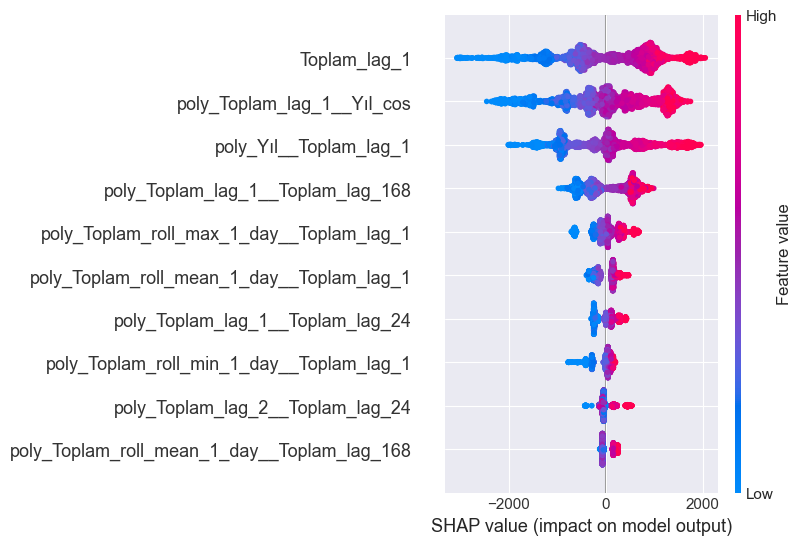

In [85]:
shap.summary_plot(shap_values, Xs_val, max_display=10)

Özellik seçimi, model yapımında kullanılmak üzere ilgili özelliklerin bir alt kümesini seçme işlemidir. Aşırı uyumu azaltmaya, model doğruluğunu iyileştirmeye ve eğitim süresini kısaltmaya yardımcı olabileceğinden makine öğrenimi sürecinde önemli bir adımdır. skforecast'in temel regresörleri scikit-learn API'sini takip ettiğinden, select_features() fonksiyonu ile scikit-learn'de bulunan özellik seçim yöntemlerini uygulamak mümkündür. En popüler yöntemlerden ikisi Özyinelemeli Özellik Eleme ve Sıralı Özellik Seçimi'dir.

In [97]:
# forecaster oluşturma
# ==============================================================================
regressor = LGBMRegressor(
                n_estimators = 100,
                max_depth = 5,
                random_state = 2241,
                verbose = -1
            )

forecaster = ForecasterAutoreg(
                 regressor = regressor,
                 lags = 24
             )

# Çapraz doğrulama ile özyinelemeli özellik eleme
# ==============================================================================
selector = RFECV(
    estimator              = regressor,
    step                   = 1,
    cv                     = 3,
    min_features_to_select = 25,
    n_jobs                 = -1
)
selected_lags, selected_exog = select_features(
    forecaster      = forecaster,
    selector        = selector,
    y               = data_train['Toplam'],
    exog            = data_train[exog_features],
    select_only     = None,
    force_inclusion = None,
    subsample       = 0.5,
    random_state    = 2241,
    verbose         = True,
)

c:\Users\Ahmet\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



Recursive feature elimination (RFECV)
-------------------------------------
Total number of records available: 14016
Total number of records used for feature selection: 7008
Number of features available: 619
    Autoreg (n=24)
    Exog    (n=595)
Number of features selected: 64
    Autoreg (n=7) : [1, 2, 4, 6, 19, 21, 23]
    Exog    (n=57) : ['Toplam_roll_mean_7_day', 'Toplam_roll_max_7_day', 'Toplam_lag_168', 'Saat_cos', 'poly_Saat__yılın_haftaları', 'poly_Saat__Toplam_lag_1', 'poly_Saat__Saat_sin', 'poly_Saat__Ay_cos', 'poly_Saat__Yıl_sin', 'poly_Saat__hafta_günü_sin', 'poly_Saat__gün_saati_sin', 'poly_Gün__Ay_cos', 'poly_Ay__Saat_cos', 'poly_Ay__gün_saati_cos', 'poly_Yıl__Toplam_lag_1', 'poly_Yıl__Toplam_lag_24', 'poly_hafta_günü__Toplam_roll_mean_7_day', 'poly_hafta_günü__Toplam_lag_2', 'poly_hafta_günü__Toplam_lag_3', 'poly_hafta_günü__Toplam_lag_168', 'poly_hafta_günü__Saat_sin', 'poly_hafta_günü__yılın_haftaları_sin', 'poly_hafta_günü__gün_saati_cos', 'poly_Toplam_roll_mean_7_d

### Optimize edilmiş LightGBM ve seçilmiş dışsal özellikler ile model oluşturulması  :

In [98]:
# forecaster oluşturma
# ==============================================================================
forecaster_tuned_lgbm_selected_exog = ForecasterAutoreg(
                 regressor = LGBMRegressor(**lgbm_params),
                 lags      = selected_lags
             )

In [102]:
# Geriye dönük test modeli
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster_tuned_lgbm_selected_exog,
                          y                  = data['Toplam'],
                          exog               = data[selected_features],
                          steps              = 24,
                          metric             = 'mean_absolute_percentage_error',
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

forecaster_tuned_lgbm_selected_exog_metric = (f"Optimize edilmiş LightGBM w/selected_exog_features MAPE: {metric}")
print(forecaster_tuned_lgbm_selected_exog_metric)
predictions.head()

  0%|          | 0/30 [00:00<?, ?it/s]

Optimize edilmiş LightGBM w/selected_exog_features MAPE: 0.024978876678274902


pred
2024-04-01 00:00:00  30226.363976
2024-04-01 01:00:00  29074.817957
2024-04-01 02:00:00  28443.927865
2024-04-01 03:00:00  28569.166529
2024-04-01 04:00:00  28783.279800

In [103]:
# Plot Tahimn vs Gerçek değer
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Toplam'], name="Gerçek değer", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="Tahmin", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Test verisinde gerçek değerler vs tahmin değerleri",
    xaxis_title="Tarih",
    yaxis_title="Toplam",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.0001,
        xanchor="left",
        x=0.001
    )
)
fig.show()

### Optimize edilmiş XGBoost ve seçilmiş dışsal özellikler ile model oluşturulması  :

In [104]:
# forecaster oluşturma
# ==============================================================================
forecaster_tuned_xgb_selected_exog = ForecasterAutoreg(
                 regressor = XGBRegressor(**xgb_params),
                 lags      = selected_lags
             )

In [105]:
# Geriye dönük test modeli
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster_tuned_xgb_selected_exog,
                          y                  = data['Toplam'],
                          exog               = data[selected_features],
                          steps              = 24,
                          metric             = 'mean_absolute_percentage_error',
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

forecaster_tuned_xgb_selected_exog_metric = (f"Optimize edilmiş XGBoost w/selected_exog_features MAPE: {metric}")
print(forecaster_tuned_xgb_selected_exog_metric)
predictions.head()

c:\Users\Ahmet\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



  0%|          | 0/30 [00:00<?, ?it/s]

Optimize edilmiş XGBoost w/selected_exog_features MAPE: 0.019933272490307262


pred
2024-04-01 00:00:00  30397.673828
2024-04-01 01:00:00  29523.894531
2024-04-01 02:00:00  28829.136719
2024-04-01 03:00:00  28432.666016
2024-04-01 04:00:00  28709.392578

In [106]:
# Plot Tahimn vs Gerçek değer
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Toplam'], name="Gerçek değer", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="Tahmin", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Test verisinde gerçek değerler vs tahmin değerleri",
    xaxis_title="Tarih",
    yaxis_title="Toplam",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.0001,
        xanchor="left",
        x=0.001
    )
)
fig.show()

### Optimize edilmiş RandomForest ve seçilmiş dışsal özellikler ile model oluşturulması  :

In [107]:
# forecaster oluşturma
# ==============================================================================
forecaster_tuned_rf_selected_exog = ForecasterAutoreg(
                 regressor = RandomForestRegressor(**rf_params),
                 lags      = selected_lags
             )

In [108]:
# Geriye dönük test
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster_tuned_rf_selected_exog,
                          y                  = data['Toplam'],
                          exog               = data[selected_features],
                          steps              = 24,
                          metric             = 'mean_absolute_percentage_error',
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

forecaster_tuned_rf_exog_metric = (f"Optimize edilmiş RandomForest w/selected_exog_features MAPE: {metric}")
print(forecaster_tuned_rf_exog_metric)
predictions.head()


c:\Users\Ahmet\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



  0%|          | 0/30 [00:00<?, ?it/s]

Optimize edilmiş RandomForest w/selected_exog_features MAPE: 0.022662274550961946


pred
2024-04-01 00:00:00  30054.067897
2024-04-01 01:00:00  29439.170420
2024-04-01 02:00:00  28515.891205
2024-04-01 03:00:00  27981.643762
2024-04-01 04:00:00  28061.148623

In [109]:
# Plot Tahimn vs Gerçek değer
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Toplam'], name="Gerçek değer", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="Tahmin", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Test verisinde gerçek değerler vs tahmin değerleri",
    xaxis_title="Tarih",
    yaxis_title="Toplam",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.0001,
        xanchor="left",
        x=0.001
    )
)
fig.show()